# Causal Discovery with Plackett-Luce

In [3]:
import numpy as np
import random
from tqdm.notebook import tqdm
from copy import deepcopy
import time
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pytorch_lightning as pl
pl.seed_everything(42)

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.reset_orig()

Global seed set to 42


In [4]:
from graph_discovery import GraphDiscoveryDAG
from estimators import to_z, to_b
from distributions import PlackettLuce
from utils import make_permutation_matrix, combine_order_and_adjmatrix
from causal_graphs.graph_generation import generate_categorical_graph, generate_chain, generate_random_graph, VariableGraph
from causal_graphs.graph_visualization import visualize_graph
from causal_graphs.graph_utils import adj_matrix_to_edges

In [5]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Graph and dataset setup

In [6]:
NUM_VARS = 3
NUM_CATEGS = 2

In [7]:
class CategoricalData(torch.utils.data.Dataset):
    
    def __init__(self, graph, dataset_size):
        super().__init__()
        self.graph = graph
        self.var_names = [v.name for v in self.graph.variables]
        data = graph.sample(batch_size=dataset_size, as_array=True)
        self.data = torch.from_numpy(data).long()
        
    
    def __len__(self):
        return self.data.shape[0]
    
    
    def __getitem__(self, idx):
        return self.data[idx]

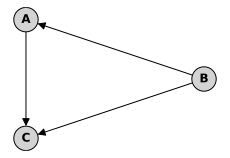

In [8]:
graph = generate_categorical_graph(num_vars=NUM_VARS,
                                   min_categs=NUM_CATEGS,
                                   max_categs=NUM_CATEGS,
                                   edge_prob=1.0,
                                   connected=True,
                                   seed=42)
visualize_graph(graph, show_plot=True, figsize=(3, 2), layout="circular")

In [9]:
dataset = CategoricalData(graph, dataset_size=64*128)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

## Testing discovery methods

### Masking

In [10]:
z = torch.randn(4)
b = to_b(z)
P = make_permutation_matrix(b)

print("z", z)
print("b", b)
print("P", P)

z tensor([0.3367, 0.1288, 0.2345, 0.2303])
b tensor([0, 2, 3, 1])
P tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])


In [11]:
A = torch.arange(16).reshape(4, 4) + 1
order = torch.LongTensor([3, 0, 2, 1])

print("A", A)
print("Order", order)
print("Combined A", combine_order_and_adjmatrix(A, order))

A tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]])
Order tensor([3, 0, 2, 1])
Combined A tensor([[ 0.,  2.,  3.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [13., 14., 15.,  0.]])


Desired result:

$$\hat{A}=\begin{bmatrix}0 & 2 & 3 & 0\\0 & 0 & 0 & 0\\ 0 & 10 & 0 & 0\\ 13 & 14 & 15 & 0\end{bmatrix}$$

### Sampling

In [12]:
discovery_module = GraphDiscoveryDAG(graph=graph, model_iters=1000, lambda_sparse=0.001, batch_size=128)
print(discovery_module.gamma)

Parameter containing:
tensor([[-9.0000e+15,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -9.0000e+15,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -9.0000e+15]], requires_grad=True)


In [13]:
s = discovery_module.sample_func(sample_matrix=torch.sigmoid(discovery_module.gamma), batch_size=4)
assert (s[:,torch.arange(s.shape[1]),torch.arange(s.shape[2])] == 0).all(), "All diagonal elements have to be 0!"
assert ((s * s.transpose(-1,-2)) == 0).all(), "No two-way connections are allowed"
assert (s.sum(dim=2) == 0).any(dim=1).all(), "At least one node needs to be a leaf-node"
assert (s.sum(dim=1) == 0).any(dim=1).all(), "At least one node needs to be a head-node"
print(s)

tensor([[[0., 0., 0.],
         [1., 0., 1.],
         [0., 0., 0.]],

        [[0., 0., 1.],
         [1., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]]])


In [33]:
def get_all_orders(var_list, s_list=None):
    if s_list is None:
        s_list = []
    if isinstance(var_list, int):
        var_list = [i for i in range(var_list)]
    
    for i in var_list:
        sub_var_list = [j for j in var_list if i != j]
        if len(sub_var_list) == 0:
            s_list.append([i])
        else:
            sub_var_list = get_all_orders(var_list=sub_var_list)
            for l in sub_var_list:
                s_list.append([i] + l)
    return s_list

In [34]:
get_all_orders(4)

[[0, 1, 2, 3],
 [0, 1, 3, 2],
 [0, 2, 1, 3],
 [0, 2, 3, 1],
 [0, 3, 1, 2],
 [0, 3, 2, 1],
 [1, 0, 2, 3],
 [1, 0, 3, 2],
 [1, 2, 0, 3],
 [1, 2, 3, 0],
 [1, 3, 0, 2],
 [1, 3, 2, 0],
 [2, 0, 1, 3],
 [2, 0, 3, 1],
 [2, 1, 0, 3],
 [2, 1, 3, 0],
 [2, 3, 0, 1],
 [2, 3, 1, 0],
 [3, 0, 1, 2],
 [3, 0, 2, 1],
 [3, 1, 0, 2],
 [3, 1, 2, 0],
 [3, 2, 0, 1],
 [3, 2, 1, 0]]

In [47]:
order_samples = torch.LongTensor(get_all_orders(5))
theta_grads, debug = discovery_module.updateModule.order_gradient_estimator(logregret=torch.zeros(order_samples.shape),
                                                                            order_samples=order_samples,
                                                                            pl_thetas=torch.zeros(order_samples.shape[-1]),
                                                                            var_idx=0)

In [48]:
order_samples

tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 4, 3],
        [0, 1, 3, 2, 4],
        [0, 1, 3, 4, 2],
        [0, 1, 4, 2, 3],
        [0, 1, 4, 3, 2],
        [0, 2, 1, 3, 4],
        [0, 2, 1, 4, 3],
        [0, 2, 3, 1, 4],
        [0, 2, 3, 4, 1],
        [0, 2, 4, 1, 3],
        [0, 2, 4, 3, 1],
        [0, 3, 1, 2, 4],
        [0, 3, 1, 4, 2],
        [0, 3, 2, 1, 4],
        [0, 3, 2, 4, 1],
        [0, 3, 4, 1, 2],
        [0, 3, 4, 2, 1],
        [0, 4, 1, 2, 3],
        [0, 4, 1, 3, 2],
        [0, 4, 2, 1, 3],
        [0, 4, 2, 3, 1],
        [0, 4, 3, 1, 2],
        [0, 4, 3, 2, 1],
        [1, 0, 2, 3, 4],
        [1, 0, 2, 4, 3],
        [1, 0, 3, 2, 4],
        [1, 0, 3, 4, 2],
        [1, 0, 4, 2, 3],
        [1, 0, 4, 3, 2],
        [1, 2, 0, 3, 4],
        [1, 2, 0, 4, 3],
        [1, 2, 3, 0, 4],
        [1, 2, 3, 4, 0],
        [1, 2, 4, 0, 3],
        [1, 2, 4, 3, 0],
        [1, 3, 0, 2, 4],
        [1, 3, 0, 4, 2],
        [1, 3, 2, 0, 4],
        [1, 3, 2, 4, 0],


In [49]:
debug["comp_matrix"]

tensor([[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]],

        [[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.]],

        [[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 1.],
         [0., 0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0., 0.],
         [1., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.]],

        [[0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.]],

        [[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.]]])

In [50]:
debug["graph_weight_red"][:,1:2,2:3].shape

torch.Size([120, 1, 1])

In [51]:
(debug["comp_matrix"] * debug["graph_weight_red"][:,1:2,2:3])[torch.where(debug["comp_matrix"][:,1,2] == 1.0)].mean(dim=0)

tensor([[0.0000, 0.2250, 0.4500, 0.5484, 0.5484],
        [0.8719, 0.0000, 1.0969, 0.8719, 0.8719],
        [0.6469, 0.0000, 0.0000, 0.6469, 0.6469],
        [0.5484, 0.2250, 0.4500, 0.0000, 0.5484],
        [0.5484, 0.2250, 0.4500, 0.5484, 0.0000]])

In [52]:
(debug["comp_matrix"] * debug["graph_weight_red"][:,2:3,1:2])[torch.where(debug["comp_matrix"][:,2,1] == 1.0)].mean(dim=0)

tensor([[0.0000, 0.4500, 0.2250, 0.5484, 0.5484],
        [0.6469, 0.0000, 0.0000, 0.6469, 0.6469],
        [0.8719, 1.0969, 0.0000, 0.8719, 0.8719],
        [0.5484, 0.4500, 0.2250, 0.0000, 0.5484],
        [0.5484, 0.4500, 0.2250, 0.5484, 0.0000]])

We expect that any edge to or from $B$ must be with 50 chance, others are irrelevant.

### Fitting

In [12]:
true_gamma = torch.from_numpy(graph.adj_matrix).float()
true_gamma = true_gamma + true_gamma.T
true_gamma.masked_fill_(true_gamma == 0, -9e15)
true_gamma.masked_fill_(true_gamma == 1, 9e15)
discovery_module.gamma.data = true_gamma.contiguous()

In [13]:
discovery_module.model_fitting_step()

In [14]:
discovery_module.scoringModule.N_s = 1 
discovery_module.scoringModule.C_s = 200
# discovery_module.scoringModule.batch_size = 2048
debug_dicts = {}
pl.seed_everything(40)
for idx in range(graph.num_vars):
    print("Intervention on variable", graph.variables[idx].name)
    debug_dicts[idx] = list()
    for _ in range(4):
        gammagrad, logregret, gammamask, theta_z, theta_b, var_idx, debug_score = discovery_module.scoringModule.score(discovery_module.gamma, discovery_module.pl_thetas, var_idx=idx, return_debug=True)
        theta_grads, debug = discovery_module.updateModule.order_gradient_estimator(logregret, theta_b, discovery_module.pl_thetas, var_idx)
        debug["gammamask"] = gammamask
        debug["scoring"] = debug_score
        debug_dicts[idx].append(debug)
        print("Theta grads", theta_grads)

Global seed set to 40


Intervention on variable B
Theta grads tensor([0.0000, 0.0238, 0.0184])
Theta grads tensor([0.0000, 0.0038, 0.0366])
Theta grads tensor([0.0000, 0.0756, 0.0052])
Theta grads tensor([ 0.0000,  0.0683, -0.0102])
Intervention on variable A
Theta grads tensor([-0.1648,  0.0000,  0.0206])
Theta grads tensor([-0.0393,  0.0000,  0.0159])
Theta grads tensor([ 0.0182,  0.0000, -0.0311])
Theta grads tensor([-0.3872,  0.0000, -0.0068])
Intervention on variable C
Theta grads tensor([-0.0256,  0.0669,  0.0000])
Theta grads tensor([-0.0264,  0.0574,  0.0000])
Theta grads tensor([ 0.0298, -0.0166,  0.0000])
Theta grads tensor([0.0027, 0.0020, 0.0000])


In [15]:
debug_dicts[0][0]["order_samples"][0]

tensor([1, 2, 0])

In [28]:
debug_dicts[0][0]["comp_matrix"][0]

tensor([[0., 0., 0.],
        [1., 0., 1.],
        [1., 0., 0.]])

In [16]:
debug_dicts[0][0]["graph_weight"][0]

tensor([[[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.7500],
         [1.0000, 1.5000, 1.0000]],

        [[1.0000, 1.0000, 0.7500],
         [1.0000, 1.0000, 1.0000],
         [1.5000, 1.0000, 1.0000]],

        [[1.0000, 0.7500, 1.0000],
         [0.7500, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]]])

In [17]:
debug_dicts[0][0]["graph_weight_red"][0]

tensor([[1.0000, 0.7500, 1.5000],
        [0.7500, 1.0000, 1.5000],
        [0.7500, 0.7500, 1.0000]])

In [18]:
debug_dicts[0][0]["eye_mask"]

tensor([[[[0., 0., 0.],
          [0., 0., 1.],
          [0., 1., 0.]],

         [[0., 0., 1.],
          [0., 0., 0.],
          [1., 0., 0.]],

         [[0., 1., 0.],
          [1., 0., 0.],
          [0., 0., 0.]]]])

In [19]:
debug_dicts[0][0]["factor_A_B"]

tensor([[[0.7500, 0.7500, 0.7500],
         [0.7500, 0.7500, 0.7500],
         [0.7500, 0.7500, 0.7500]],

        [[0.7500, 0.7500, 0.7500],
         [0.7500, 0.7500, 0.7500],
         [0.7500, 0.7500, 0.7500]],

        [[0.7500, 0.7500, 0.7500],
         [0.7500, 0.7500, 0.7500],
         [0.7500, 0.7500, 0.7500]]])

In [20]:
debug_dicts[0][0]["factor_neg_A_B"]

tensor([[[1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000]],

        [[1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000]],

        [[1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000],
         [1.5000, 1.5000, 1.5000]]])

In [21]:
debug_dicts[0][0]["p_A_C_gA_B"]

tensor([[[0.6667, 0.6667, 0.6667],
         [0.6667, 0.6667, 0.6667],
         [0.6667, 0.6667, 0.6667]],

        [[0.6667, 0.6667, 0.6667],
         [0.6667, 0.6667, 0.6667],
         [0.6667, 0.6667, 0.6667]],

        [[0.6667, 0.6667, 0.6667],
         [0.6667, 0.6667, 0.6667],
         [0.6667, 0.6667, 0.6667]]])

In [26]:
debug_dicts[0][0]["factor_comb_A_B"][0]

tensor([[[1.5000, 1.5000, 1.5000],
         [0.7500, 1.5000, 0.7500],
         [0.7500, 1.5000, 1.5000]],

        [[1.5000, 1.5000, 1.5000],
         [0.7500, 1.5000, 0.7500],
         [0.7500, 1.5000, 1.5000]],

        [[1.5000, 1.5000, 1.5000],
         [0.7500, 1.5000, 0.7500],
         [0.7500, 1.5000, 1.5000]]])

In [27]:
debug_dicts[0][0]["factor_comb_B_A"][0]

tensor([[[0.7500, 0.7500, 0.7500],
         [1.5000, 0.7500, 1.5000],
         [1.5000, 0.7500, 0.7500]],

        [[0.7500, 0.7500, 0.7500],
         [1.5000, 0.7500, 1.5000],
         [1.5000, 0.7500, 0.7500]],

        [[0.7500, 0.7500, 0.7500],
         [1.5000, 0.7500, 1.5000],
         [1.5000, 0.7500, 0.7500]]])

In [ ]:
debug_dicts[0][0]["factor_comb_B_A"][0]

In [24]:
(debug_dicts[0][0]["comp_matrix"] * debug_dicts[0][0]["graph_weight_red"])[torch.where(debug_dicts[0][0]["comp_matrix"][:,1,2] == 1.0)].mean(dim=0)

tensor([[0.0000, 0.4902, 0.4975],
        [0.7574, 0.0000, 1.0025],
        [0.2525, 0.0000, 0.0000]])

In [25]:
(debug_dicts[0][0]["comp_matrix"])[torch.where(debug_dicts[0][0]["comp_matrix"][:,1,2] == 1.0)].mean(dim=0)

tensor([[0.0000, 0.3268, 0.6634],
        [0.6732, 0.0000, 1.0000],
        [0.3366, 0.0000, 0.0000]])

In [21]:
debug_dicts[0][0]["comp_grads"].mean(dim=0)

tensor([[ 0.5000,  0.0130,  0.0035],
        [-0.0130,  0.5000, -0.0095],
        [-0.0035,  0.0095,  0.5000]])

In [ ]:
debug_dicts[0][3]["logregret"][5,0,-1].squeeze()

In [ ]:
torch.where(debug_dicts[0][3]["logregret"][:,0,-1] == 1)

In [ ]:
debug_dicts[0][3]["comp_matrix"][17]

In [ ]:
debug_dicts[0][3]["gammamask"][5]

In [ ]:
debug_dicts[0][3]["pairgrads"]

In [ ]:
debug_dicts[0][3]["pairgrads"].sum(dim=1)[1:] - 0.5

In [ ]:
- debug_dicts[0][3]["pairgrads"].sum(dim=0)[1:] + 0.5

In [ ]:
pl.seed_everything(40)
batch = torch.randint(NUM_CATEGS, size=(16, NUM_VARS))
batch[:,2] = 0

In [ ]:
nll = discovery_module.scoringModule.evaluate_likelihoods(batch, debug_dicts[1][3]["gammamask"][0:1].expand(batch.shape[0],-1,-1), var_idx=0)
print(nll.shape)

In [ ]:
nll

In [ ]:
debug_dicts[]

## Scoring

In [ ]:
gammagrad, logregret, gammamask, theta_z, theta_b, var_idx = discovery_module.scoringModule.score(discovery_module.gamma, discovery_module.pl_thetas)

In [ ]:
theta_b.shape

## Update

In [ ]:
gammamask.shape

In [ ]:
logregret.shape

In [ ]:
discovery_module.updateModule.update(gammagrad, logregret, gammamask, discovery_module.gamma, var_idx,
                                     theta_z, theta_b, discovery_module.pl_thetas, discovery_module.pl_critic)

## Loop

In [ ]:
discovery_module.discover_graph(num_epochs=2)

In [ ]:
discovery_module.get_binary_adjmatrix()

In [ ]:
torch.round(torch.sigmoid(discovery_module.gamma) * 100) / 100

In [ ]:
graph.adj_matrix

In [ ]:
discovery_module.get_binary_adjmatrix() * 1

In [ ]:
discovery_module.pl_thetas

In [ ]:
discovery_module.pl_thetas.grad

In [ ]:
print(graph)

In [ ]:
def visu_graph(adj_matrix):
    copy_graph = deepcopy(discovery_module.scoringModule.graph)
    copy_graph.adj_matrix = discovery_module.get_binary_adjmatrix().detach().cpu().numpy()
    copy_graph.edges = adj_matrix_to_edges(copy_graph.adj_matrix)
    visualize_graph(copy_graph, 
                    show_plot=True,
                    figsize=(4, 4), 
                    layout="circular")

In [ ]:
visu_graph(discovery_module.get_binary_adjmatrix())

In [ ]:
gammagrad, logregret, gammamask, theta_z, theta_b, var_idx = discovery_module.scoringModule.score(discovery_module.gamma, discovery_module.pl_thetas)

In [ ]:
theta_grads, debug = discovery_module.updateModule.order_gradient_estimator(logregret, theta_b, discovery_module.pl_thetas, var_idx)
pairgrads = debug["pairgrads"]
print("Theta grads\n" + str(theta_grads))
print("\nPair grads\n" + str(pairgrads))

In [ ]:
pairgrads.sum(dim=1) - 0.5

In [ ]:
pairgrads.sum(dim=0) - 0.5

In [ ]:
theta_b

In [ ]:
debug["logregret"].squeeze()

In [ ]:
torch.unique(debug["logregret"].squeeze()[:,1])

In [ ]:
debug["comp_matrix"][-1]

In [ ]:
debug["comp_matrix"][:,2,1]

In [ ]:
debug["logregret"].shape

In [ ]:
pos_regret = (debug["comp_matrix"] * debug["logregret"]).sum(dim=0) / debug["comp_matrix"].sum(dim=0)
print("Positive regret")
print(pos_regret)

In [ ]:
neg_regret = ((1-debug["comp_matrix"]) * debug["logregret"]).sum(dim=0) / (1-debug["comp_matrix"]).sum(dim=0)
print("Negative regret")
print(neg_regret)

In [ ]:
debug["logregret"][torch.where(debug["comp_matrix"][:,2,1] == 0)[0],0,1]

In [ ]:
theta_b[torch.where(debug["comp_matrix"][:,2,1] == 0)[0]]

In [ ]:
d = PlackettLuce(discovery_module.pl_thetas)
order_samples = torch.LongTensor([[0, 1, 2],
                                  [0, 2, 1],
                                  [1, 2, 0],
                                  [1, 0, 2],
                                  [2, 0, 1],
                                  [2, 1, 0]])
d.log_prob(order_samples).exp()

In [ ]:
debug["comp_matrix"].mean(dim=0)

In [ ]:
debug["comp_probs"]

In [ ]:
(pos_regret < neg_regret).long()

In [ ]:
debug["comp_matrix"][3]

In [ ]:
theta_b[3]

In [ ]:
nomin = (debug["comp_probs"] * (debug["comp_probs"] - 1) * pos_regret + (1 - debug["comp_probs"]) * (debug["comp_probs"] - 0) * neg_regret)

In [ ]:
denom = debug["comp_probs"] * pos_regret + (1 - debug["comp_probs"]) * neg_regret

In [ ]:
nomin / denom

## Estimators

### Reinforce

In [ ]:
from DAG_generation.estimators import reinforce

In [ ]:
fb = torch.FloatTensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
b = torch.LongTensor([[0, 1, 2],
                      [0, 2, 1],
                      [1, 2, 0],
                      [1, 0, 2],
                      [2, 0, 1],
                      [2, 1, 0]])
thetas = nn.Parameter(torch.FloatTensor([0.0,0.0,0.0]))
optim = torch.optim.SGD([thetas], lr=1e-2)

In [ ]:
for _ in range(100):
    thetas_exp = thetas[None].expand(b.shape[0], -1)
    g = reinforce(fb, b, thetas_exp)
    print("G", g)
    thetas.backward(g.mean(dim=0))
    optim.step()
    print("Thetas", thetas)

### Pairwise gradient estimator

In [ ]:
order_samples = torch.LongTensor([[0, 1, 2],
                                  [0, 2, 1],
                                  [1, 2, 0],
                                  [1, 0, 2],
                                  [2, 0, 1],
                                  [2, 1, 0]])
pl_thetas = nn.Parameter(torch.FloatTensor([0.02,0.0,-0.02]))
prob = torch.FloatTensor([[0.4, 0.6, 0.6],
                          [0.4, 0.6, 0.4],
                          [0.4, 0.4, 0.4],
                          [0.4, 0.4, 0.6],
                          [0.4, 0.6, 0.2],
                          [0.4, 0.4, 0.2]])
logregret = prob.unsqueeze(dim=1)

In [ ]:
# Get a matrix for 1[pi_j > pi_i]
pos = (F.one_hot(order_samples, order_samples.shape[-1]) * torch.arange(order_samples.shape[-1])[None,:,None]).sum(dim=-2)
comp_matrix = (pos[...,None] < pos[...,None,:]).float()
print("Comp matrix")
print(comp_matrix)

In [ ]:
# Get a matrix for p(pi_j > pi_i). Dim=0 => theta_j, Dim=1 => theta_i
comp_probs = torch.softmax(torch.stack([pl_thetas[None,:].expand(pl_thetas.shape[-1],-1), # theta_i 
                                        pl_thetas[:,None].expand(-1,pl_thetas.shape[-1])  # theta_j
                                        ], dim=-1), dim=-1)[...,1]
print("Comp probs")
print(comp_probs)

In [ ]:
comp_grads = (comp_probs - comp_matrix)
print("Comp grads")
print(comp_grads)

In [ ]:
nomin = logregret * comp_grads
denom = logregret

print("Nomin")
print(nomin)
print("Denom")
print(denom)

In [ ]:
nomin, denom = nomin.sum(dim=0), denom.sum(dim=0)
denom.masked_fill_(denom == 0.0, 1e-5)

pairgrads = nomin / denom 

print("Pair grads")
print(pairgrads)

In [ ]:
grads = pairgrads.sum(dim=1) - pairgrads.sum(dim=0)
print("Grads", grads)

In [ ]:
a = nn.Parameter(torch.zeros(3,))
optim = torch.optim.Adam([a], lr=1e-3)
a.grad = torch.ones(a.shape)
optim.step()
print(a)